In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os
import itertools

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from bsub import bsub

In [165]:
def reduce(**kwargs):
    """
    Bias-subtract and normalize science images.
    """  
    dataf = kwargs.get('dataf')
    flatf = kwargs.get('flatf')
    
    flat = fits.getdata(flatf)
    dat = fits.getdata(dataf)
    hdr = fits.getheader(dataf)

    #Bias subtract
    datab = bsub(dat, hdr.get('cover')) 
    flatb = bsub(flat, hdr.get('cover')) 
    
    #Normalize
    flatb = flatb/np.median(flatb)
    reduced = datab/flatb
    
    return reduced

def plotImg(arr, **kwargs):
    """
    Plot 2D science image with identified objects.
    """
    avg = np.mean(arr.flatten())
    std = np.std(arr.flatten())
    dim = arr.shape
    rng = kwargs.get('rng', [np.percentile(arr, 5), np.percentile(arr, 95)])
    
    fig, ax = plt.subplots(1)
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray_r', \
                    vmin=rng[0], vmax=rng[1])
    
    if 'pts' in kwargs:
        pts = kwargs.get('pts')
        plt.scatter(pts[0], pts[1], marker='o', s=50, facecolors='none', edgecolors='r')

    plt.colorbar(pl).set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.xlim(0, dim[0])
    plt.ylim(0, dim[1])
    if 'title' in kwargs:
        plt.title(kwargs.get('title'))
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

In [167]:
def findStar(red, **kwargs):
    """
    Find all points in a 2D image with ADU counts above a percentile threshold.
    """
    perc = kwargs.get('perc', 99)
    cut = np.percentile(red.flatten(), perc)
    
    pts = []
    for row in range(red.shape[0]):
        idx = np.where(red[row] >= cut)[0]
        if len(idx) != 0:
            for col in idx:
                pts.append([row, col])
    pts = np.array(pts)
    
    return pts

def dist(r1, r2):
    """
    Return Euclidean distance between two 2D vectors.
    """
    return np.sqrt((r1[0]-r2[0])**2 + (r1[1]-r2[1])**2)

In [282]:
def removePixels(pts, **kwargs):
    """
    Remove points associated with bad rows or columns of the detector.
    """
    rows = kwargs.get('rows', [])
    cols = kwargs.get('cols', [])
    
    xpts, ypts = [], []
    for p in star_pts:
        if p[1] not in cols:
            xpts.append(p[0])
            ypts.append(p[1])
    pts = np.array([ypts, xpts])
    
    return pts.T

def clusterPoints(points, **kwargs):
    """
    Cluster points into separate arrays if they are within the distance
    of a specified radius.
    """
    radius = kwargs.get('radius', 5)

    clusters = []
    while len(points) > 0:
        p0 = points[0]
        clus = []
        new_list = []
        for pt in points:
            if dist(p0, pt) < radius**2:
                clus.append(pt)
            else:
                new_list.append(pt)
        clusters.append(np.array(clus))
        points = new_list
    
    return np.array(clusters)

def findClusterMax(red, clusters):
    """
    Given clusters of bright points, find the pixel positions
    corresponding to max ADU count in each cluster.
    """
    peaks = []
    for clus in clusters:
        adu_vals = []
        for pt in clus:
            adu_vals.append(red[pt[0], pt[1]])
        max_adu_idx = np.where(adu_vals == max(adu_vals))[0][0]
        peaks.append(clus[max_adu_idx])
        
    return np.array(peaks)

def selectCircle(**kwargs):
    """
    Select a circle of discrete points centered around 'xc' and 'yc' within 
    a given radius size, and within the square dimensions of the image size.
    """
    xc, yc = kwargs.get('xc'), kwargs.get('yc')
    radius = kwargs.get('radius')
    dim = kwargs.get('dim', [np.inf, np.inf])
    
    ylist = np.arange(yc-radius, yc+radius+1)
    xlist = np.arange(xc-radius, xc+radius+1)
    square_cut = [list(xy) for xy in list(itertools.product(ylist, xlist))]

    circle_cut = []
    for pt in square_cut:
        if (dist([yc,xc], pt) < radius) & (0 <= pt[0] < dim[0]) & (0 <= pt[1] < dim[1]):
            circle_cut.append(pt)
            
    return circle_cut

def centroid(red, peaks, **kwargs):
    """
    Given peak pixels of stars, cut out a radius of pixels and
    compute sub-pixel centroids and errors
    """
    radius = kwargs.get('radius', 20)
    
    centroids = []
    for pt in peaks:
        circle = selectCircle(yc=pt[0], xc=pt[1], radius=radius, dim=red.shape)
        
        I, xI, yI = [], [], []
        for yx in circle:
            I.append(red[yx[0], yx[1]])
            yI.append(red[yx[0], yx[1]]*yx[0])
            xI.append(red[yx[0], yx[1]]*yx[1])
        ycent = sum(yI)/sum(I)
        xcent = sum(xI)/sum(I)
        centroids.append([ycent, xcent])
    
    return np.array(centroids)

In [164]:
red = reduce(dataf='data/demo/d159.fits', flatf='data/demo/d121.fits')

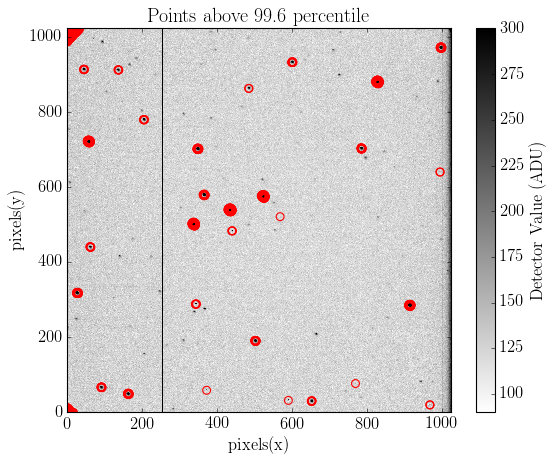

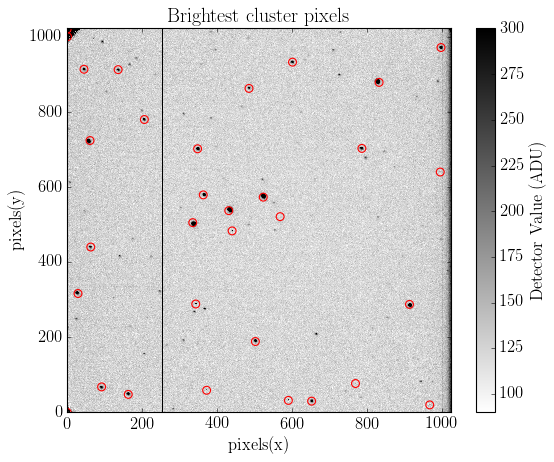

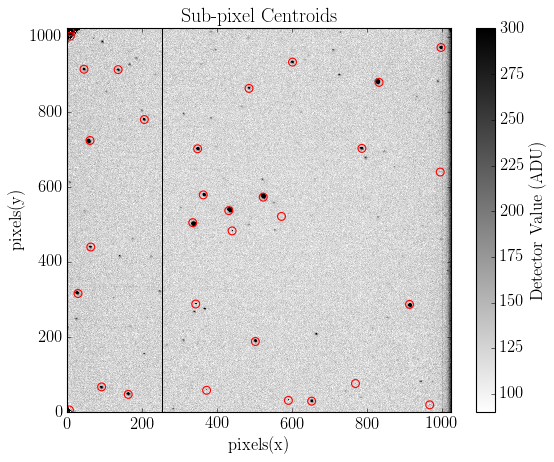

In [287]:
perc = 99.6
star_pts = findStar(red, perc=perc)

bad_col = [255, 256] + list(np.arange(1000,1025))
ptlist = removePixels(star_pts, cols=bad_col)

clusters = clusterPoints(ptlist, radius=5)
peak_pixels = findClusterMax(red, clusters)
centroids = centroid(red, peak_pixels)

plotImg(red, pts=ptlist.T, rng=[90,300], title='Points above %s percentile'%(perc), \
        save='writeup/plots/identification1.png')
plotImg(red, pts=peak_pixels.T, rng=[90,300], title='Brightest cluster pixels', \
        save='writeup/plots/identification2.png')
plotImg(red, pts=centroids.T, rng=[90,300], title='Sub-pixel Centroids', \
        save='writeup/plots/identification3.png')

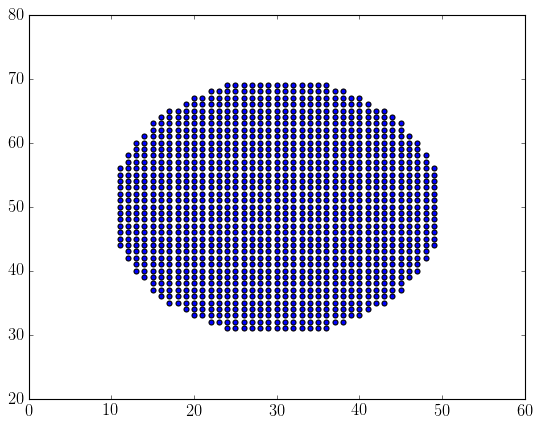

In [285]:
circle_cut = selectCircle(xc=50, yc=30, radius=20)
plt.scatter(np.array(circle_cut).T[0], np.array(circle_cut).T[1])
plt.show()

In [286]:
centroids

array([[   5.96605028,    6.42422933],
       [ 966.94950263,   20.12594076],
       [ 652.02498603,   30.00309743],
       [ 590.0135554 ,   31.96754386],
       [ 162.98140011,   47.98705034],
       [ 371.95925853,   58.9787835 ],
       [  92.00785651,   67.99843393],
       [ 768.94191359,   76.94967044],
       [ 501.97931436,  189.04140849],
       [ 913.03277877,  287.9917969 ],
       [ 342.96838761,  288.97396994],
       [  29.03115417,  316.99449502],
       [  63.02515718,  441.00589685],
       [ 439.98351859,  483.99752141],
       [ 334.96041763,  505.9822313 ],
       [ 571.66288101,  522.56530678],
       [ 430.94993137,  538.00705327],
       [ 522.95686656,  574.03293655],
       [ 363.0326814 ,  580.02048106],
       [ 994.99080603,  640.94731656],
       [ 348.02251463,  703.00460171],
       [ 786.01398384,  703.96731976],
       [  60.9763292 ,  725.1182637 ],
       [ 206.01095221,  780.99444734],
       [ 485.00897585,  864.00145541],
       [ 831.95878794,  8